In [0]:
import numpy as np
import pandas as pd
import pylab as plt 

from google.colab import drive
import sqlite3
import seaborn as sns

from scipy.stats import binned_statistic, binned_statistic_2d
from scipy.stats import randint as sp_randint , uniform

from matplotlib.colors import BoundaryNorm, LogNorm
from statsmodels.stats.proportion import proportion_confint

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc , confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split


import pickle

In [103]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
out=pickle.load(  open( "/content/gdrive/My Drive/UD/Sbux/data/out.pkl", "rb" ) )

In [0]:
profile=pickle.load(  open( "/content/gdrive/My Drive/UD/Sbux/data/profile.pkl", "rb" ) )

In [0]:
def cmp_hist4(out,var,bins=50,loc=1,density=True):
  
  cnv= ( (out.rewarded==True)  & (  out.viewed==True )  )
  out.loc[cnv,var].hist(bins=bins,histtype='step',lw=2,label='compl. & viewed',density=density,alpha=0.5);

  cnv= ( (out.rewarded==True)  & (  out.viewed==False )  )
  out.loc[cnv,var].hist(bins=bins,histtype='step',lw=4,label='compl. not viewed',density=density,alpha=0.5);
  
  cnv= ( (out.rewarded==False)  & (  out.viewed==True )  )
  out.loc[cnv,var].hist(bins=bins,histtype='step',lw=2,label='not compl. & viewed',density=density,alpha=0.5);

  cnv= ( (out.rewarded==False)  & (  out.viewed==False )  )
  out.loc[cnv,var].hist(bins=bins,histtype='step',lw=2,label='not compl. & not viewed',density=density,alpha=0.5);
  
  
  plt.legend(loc=loc);
  plt.title(var);

In [0]:
def cmp_hist(out,var):
  
  cnv= ( (out.rewarded==True)  & (  out.viewed==True )  )
  out.loc[cnv,var].hist(bins=50,histtype='step',lw=2,label='compl. & viewed',density=True,alpha=0.5);

  cnv= ( (out.rewarded==True)  & (  out.viewed==False )  )
  out.loc[cnv,var].hist(bins=50,histtype='step',lw=2,label='compl. not viewed',density=True,alpha=0.5);
  plt.legend(loc=1);
  plt.title(var);

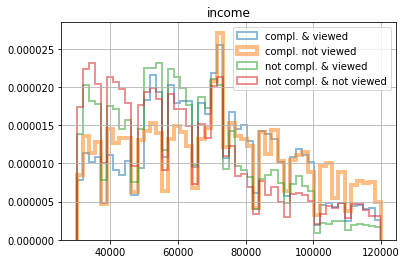

In [0]:
cmp_hist4(out,'income',bins=50,density=True)

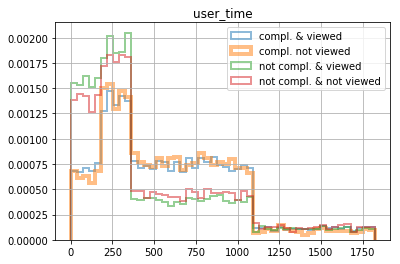

In [0]:
cmp_hist4(out,'user_time')

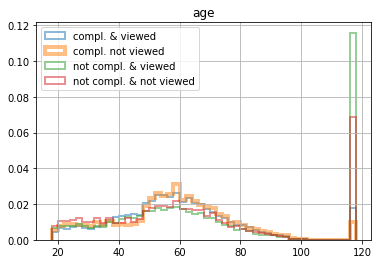

In [0]:
cmp_hist4(out,'age',loc=2)

viewed  social
False   False     0.830085
        True      0.169915
True    True      0.746761
        False     0.253239
Name: social, dtype: float64

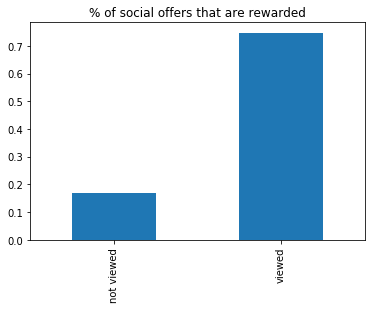

In [0]:
var='social'
vis=out.loc[out.rewarded==True].groupby(by="viewed")[var].value_counts(normalize=True)
vis.loc[vis.index.get_level_values('social')==True].plot(kind='bar')
plt.xticks([0,1],['not viewed','viewed'])
plt.xlabel('')
plt.title('% of social offers that are rewarded')
vis

mobile,False,True
viewed,,
False,0.317328,0.682672
True,0.058546,0.941454


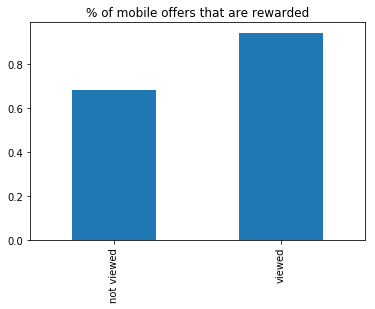

In [0]:
var='mobile'
vis=out.loc[out.rewarded==True].groupby(by="viewed")[var].value_counts(normalize=True)
vis.loc[vis.index.get_level_values(var)==True].plot(kind='bar')
plt.xticks([0,1],['not viewed','viewed'])
plt.xlabel('')
plt.title('%% of %s offers that are rewarded' % var)

vis.unstack()

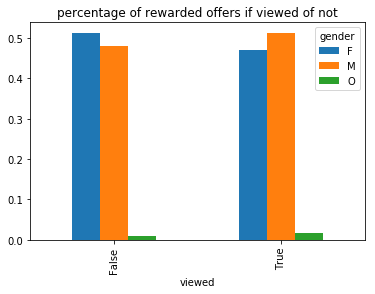

In [0]:
var='gender'
vis=out.loc[out.rewarded==True].groupby(by="viewed")[var].value_counts(normalize=True).unstack()

vis.plot(kind='bar')
plt.title('percentage of rewarded offers if viewed of not');


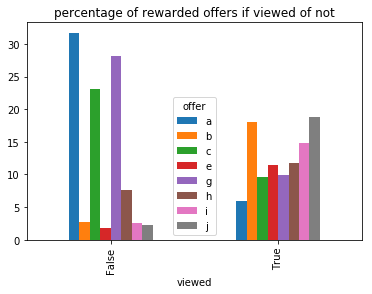

In [0]:
var='offer'
vis=100*out.loc[out.rewarded==True].groupby(by="viewed")[var].value_counts(normalize=True).unstack()

vis.plot(kind='bar')
plt.title('percentage of rewarded offers if viewed of not');


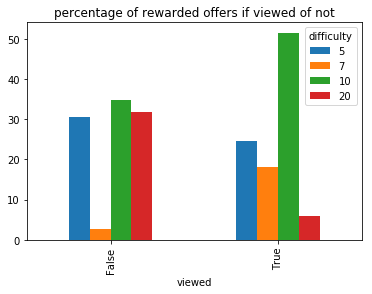

In [0]:
var='difficulty'
vis=100*out.loc[out.rewarded==True].groupby(by="viewed")[var].value_counts(normalize=True).unstack()

vis.plot(kind='bar')
plt.title('percentage of rewarded offers if viewed of not');

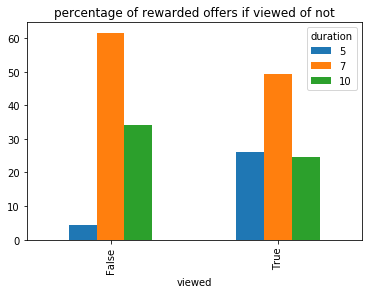

In [0]:
var='duration'
vis=100*out.loc[out.rewarded==True].groupby(by="viewed")[var].value_counts(normalize=True).unstack()

vis.plot(kind='bar')
plt.title('percentage of rewarded offers if viewed of not');

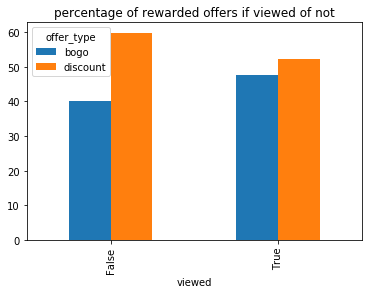

In [0]:
var='offer_type'
vis=100*out.loc[out.rewarded==True].groupby(by="viewed")[var].value_counts(normalize=True).unstack()

vis.plot(kind='bar')
plt.title('percentage of rewarded offers if viewed of not');

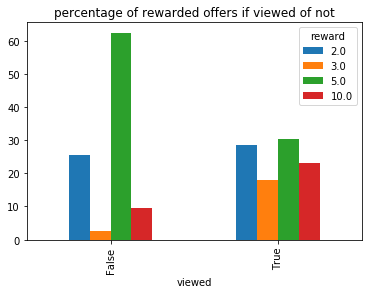

In [0]:
var='reward'
vis=100*out.loc[out.rewarded==True].groupby(by="viewed")[var].value_counts(normalize=True).unstack()

vis.plot(kind='bar')
plt.title('percentage of rewarded offers if viewed of not');

In [0]:
cnv= ( (out.rewarded==True)  & (  out.viewed==True )  )
out.loc[cnv,'social'].value_counts()



True     20574
False     6977
Name: social, dtype: int64

In [0]:
cnv= ( (out.rewarded==True)  & (  out.viewed==False )  )
out.loc[cnv,'social'].value_counts()

False    4685
True      959
Name: social, dtype: int64

In [0]:
completed_stats=out[['rewarded','completed','comp_not_viewed']].sum()
n_cnv_offers=completed_stats['comp_not_viewed']

completed_stats=completed_stats/len(out)
perc_cnv=100.*completed_stats['comp_not_viewed']



print('%3.2g%% of the total offers are rewarded even if they were not viewed\n' % (perc_cnv))
print('%3.2g%% of the rewarded offers are rewarded even if they were not viewed\n' % ( 100* completed_stats['comp_not_viewed']/(completed_stats['comp_not_viewed']+completed_stats['completed']) ))

print()
print(completed_stats.to_string())

rewards_lost=out.loc[out.comp_not_viewed,'reward'].sum()
total_rewards=out.loc[out.rewarded,'reward'].sum()

print()
print('%g$ out of total rewards %g$ could be saved (%4.3g%%)' %(rewards_lost,total_rewards,100.*rewards_lost/total_rewards))
print('average reward saved per correct offer not sent: %2.2g $' % (rewards_lost/n_cnv_offers) )


7.4% of the total offers are rewarded even if they were not viewed

 17% of the rewarded offers are rewarded even if they were not viewed


rewarded           0.435190
completed          0.361197
comp_not_viewed    0.073993

26257$ out of total rewards 162510$ could be saved (16.2%)
average reward saved per correct offer not sent: 4.7 $


In [0]:
T_offers= out['Tpay_offer'].sum()
T_rewards=out.loc[out.rewarded,'reward'].sum()

T_income_off=T_offers-T_rewards
print('total purchases in offer time: ', T_offers)
print('total rewards: ', T_rewards)
print('total income in offer time: ', T_income_off)


# TP=out.groupby(by='person')['Tpay_offers_tot'].agg('mean')
# TP.sum()

total purchases in offer time:  1356770.5283333336
total rewards:  162510.0
total income in offer time:  1194260.5283333336


In [0]:
TO=out.groupby(by='person')['Tpay_out'].agg('mean')

T_outside= TO.sum()
print('total income outside offer time: ', T_outside)

total income outside offer time:  248640.80999999997


Text(0.5, 1.0, 'more money is made during offers, even accounting for rewards')

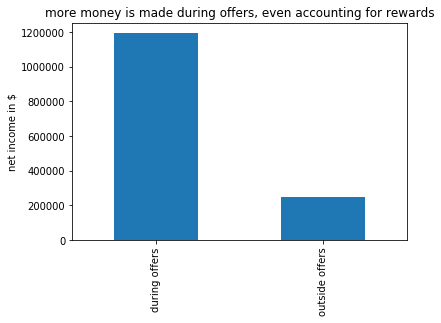

In [0]:
outcome=pd.DataFrame([[T_income_off,T_outside]],columns= ['during offers','outside offers'])
outcome.T.plot(kind='bar')
plt.gca().get_legend().remove()
plt.ylabel('net income in $');
plt.title('more money is made during offers, even accounting for rewards')


In [0]:
n_person=(np.unique(out.person)).shape[0]
print("n_person: ",n_person)

n_person:  16994


In [0]:
times=out.groupby(by='person')[['tot_net_offers_time','tot_not_offers_time']].agg('mean').sum()
print(times.to_string())


print()
print('net $/h offer :',T_income_off/times['tot_net_offers_time'])
print('$/h no offer  :',T_outside/times['tot_not_offers_time'])

net_offer_hourly=T_income_off/times['tot_net_offers_time'] - T_outside/times['tot_not_offers_time']

times=times/1e6
times=times.rename(index={'tot_net_offers_time':'hours with offers','tot_not_offers_time':'hours without offers'})

tot_net_offers_time    6259952.0
tot_not_offers_time    6383584.0

net $/h offer : 0.19077790505954895
$/h no offer  : 0.038950033398166294


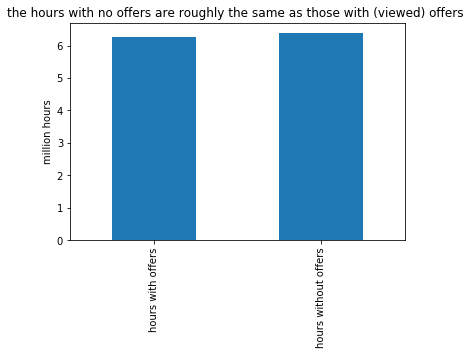

In [0]:
times.plot(kind='bar')
plt.ylabel('million hours')
plt.title('the hours with no offers are roughly the same as those with (viewed) offers ');

In [0]:
out.head()

,person,offer,offer_received,offer_viewed,offer_completed,reward,offer_end,difficulty,duration,offer_type,web,email,mobile,social,offer_reward,duration_hours,duration_viewed,duration_effective,viewed,rewarded,received,comp_not_viewed,completed,Tpay_offer,Npay_offer,Maxpay_offer,Minpay_offer,Avg_pay_offer,age,became_member_on,gender,income,joined_year,joined_month,joined_week,gender_num,user_time,Tpay_out,Npay_out,p_c_r_ratio,p_cnv_r_ratio,overlaps,Tpay_offers_tot,Npay_offers_tot,Maxpay_offers_tot,Minpay_offers_tot,tot_gross_offer_time,tot_net_offers_time,tot_not_offers_time,Avg_pay_offers,Avg_pay_outside,Avg_D_O,Avg_D_OS
0,78afa995795e4d85b5d9ceeca43f5fef,g,0,6.0,132.0,5.0,168.0,5,7,bogo,True,True,True,False,5,168.0,162.0,162.0,True,True,True,False,True,37.67,2.0,19.89,17.78,0.232531,75,2017-05-09,F,100000.0,2017,5,19,0,443,0.00,0.0,0.750000,0.0,0.0,135.34,6.0,29.72,17.78,396.0,400.0,344.0,0.338350,0.000000,0.232531,0.338350
1,ebe7ef46ea6f4963a7dd49f501b26779,g,0,NaN,NaN,0.0,168.0,5,7,bogo,True,True,True,False,5,168.0,0.0,0.0,False,False,True,False,False,0.00,0.0,NaN,NaN,0.000000,59,2015-01-21,M,41000.0,2015,1,4,1,1282,52.08,13.0,0.333333,0.0,NaN,49.17,14.0,11.50,0.69,390.0,297.0,447.0,0.165556,0.116510,-0.116510,0.049045
2,f082d80f0aac47a99173ba8ef8fc1909,g,0,48.0,12.0,5.0,168.0,5,7,bogo,True,True,True,False,5,168.0,120.0,120.0,True,True,True,False,True,14.64,4.0,11.13,0.28,0.122000,40,2016-07-09,M,33000.0,2016,7,27,1,747,40.94,14.0,0.166667,0.0,0.0,24.86,12.0,11.13,0.18,402.0,327.0,417.0,0.076024,0.098177,0.023823,-0.022153
3,c0d210398dee4a0895b24444a5fcd1d2,g,0,30.0,66.0,5.0,168.0,5,7,bogo,True,True,True,False,5,168.0,138.0,138.0,True,True,True,False,True,6.01,1.0,6.01,6.01,0.043551,45,2018-07-07,M,33000.0,2018,7,27,1,19,0.00,0.0,0.600000,0.0,0.0,54.05,10.0,9.28,3.33,570.0,482.0,262.0,0.112137,0.000000,0.043551,0.112137
4,57dd18ec5ddc46828afb81ec5977bef2,g,0,NaN,NaN,0.0,168.0,5,7,bogo,True,True,True,False,5,168.0,0.0,0.0,False,False,True,False,False,0.00,0.0,NaN,NaN,0.000000,54,2017-02-07,F,80000.0,2017,2,6,0,534,0.00,0.0,0.500000,0.0,NaN,219.54,9.0,39.79,11.66,492.0,381.0,363.0,0.576220,0.000000,0.000000,0.576220


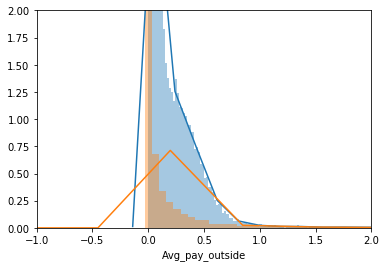

In [0]:
from scipy import stats

pg=out.groupby(by='person')[['Avg_pay_offers','Avg_pay_outside']].agg('mean')

sns.distplot(pg['Avg_pay_offers'],bins=1000)
sns.distplot(pg['Avg_pay_outside'],bins=1000)
plt.axis([-1,2,0,2]);

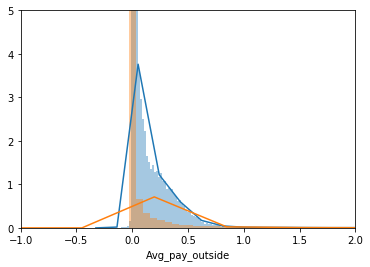

In [106]:
pg=out.groupby(by='person')[['Avg_net_pay_offers','Avg_pay_outside']].agg('mean')
sns.distplot(pg['Avg_net_pay_offers'],bins=1000)
sns.distplot(pg['Avg_pay_outside'],bins=1000)

plt.axis([-1,2,0,5]);

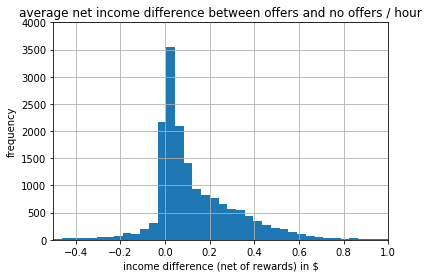

In [107]:
di=pg['Avg_net_pay_offers']-pg['Avg_pay_outside']
di.hist(bins=2000)
plt.axis([-.5,1,0,4000]);
plt.title('average net income difference between offers and no offers / hour');
plt.xlabel('income difference (net of rewards) in $')
plt.ylabel('frequency');


In [0]:
n = len(di)
reps = 10000
xb = np.random.choice(di, (n, reps))
mb = xb.mean(axis=0)
mb.sort()

mean_95p=np.percentile(mb, [0.5, 99.5])

[0.10134219 0.1304427 ]


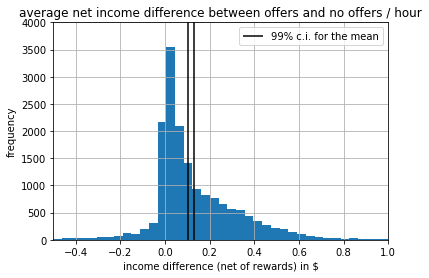

In [109]:
print(mean_95p)
di.hist(bins=2000)
plt.axis([-.5,1,0,4000]);
plt.title('average net income difference between offers and no offers / hour');
plt.xlabel('income difference (net of rewards) in $')
plt.ylabel('frequency');
plt.vlines(mean_95p,0,4000,label='99% c.i. for the mean')
plt.legend()

In [110]:
neg=di<-.03
neg=(neg.rename('neg_response')).to_frame().reset_index()
#neg.head()
display(100*neg['neg_response'].value_counts(normalize=True))

profile2=profile.merge(neg,on='person')

False    92.044251
True      7.955749
Name: neg_response, dtype: float64

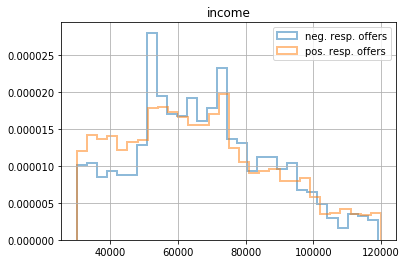

In [111]:
var='income'
bins=30
profile2.loc[profile2.neg_response==True, var].hist(bins=bins,histtype='step',lw=2,label='neg. resp. offers',density=True,alpha=0.5);
profile2.loc[profile2.neg_response==False,var].hist(bins=bins,histtype='step',lw=2,label='pos. resp. offers',density=True,alpha=0.5);

plt.legend(loc=1);
plt.title(var);

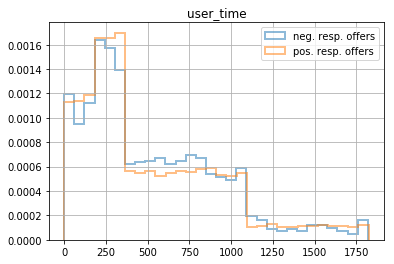

In [113]:
var='user_time'
bins=30
profile2.loc[profile2.neg_response==True, var].hist(bins=bins,histtype='step',lw=2,label='neg. resp. offers',density=True,alpha=0.5);
profile2.loc[profile2.neg_response==False,var].hist(bins=bins,histtype='step',lw=2,label='pos. resp. offers',density=True,alpha=0.5);

plt.legend(loc=1);
plt.title(var);

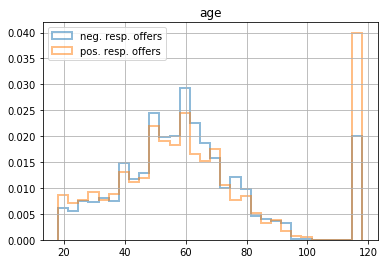

In [0]:
var='age'
bins=30
profile2.loc[profile2.neg_response==True, var].hist(bins=bins,histtype='step',lw=2,label='neg. resp. offers',density=True,alpha=0.5);
profile2.loc[profile2.neg_response==False,var].hist(bins=bins,histtype='step',lw=2,label='pos. resp. offers',density=True,alpha=0.5);

plt.legend(loc=2);
plt.title(var);

gender,F,M,O
neg_response,,,
False,0.406845,0.579141,0.014014
True,0.482567,0.500000,0.017433


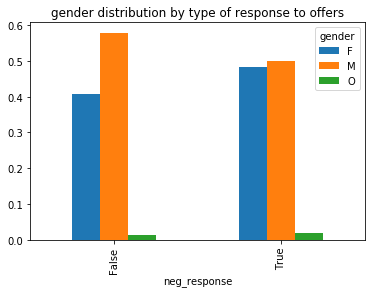

In [0]:
var='gender'
vis=profile2.groupby(by='neg_response')[var].value_counts(normalize=True).unstack()
display(vis)

vis.plot(kind='bar')
plt.title('gender distribution by type of response to offers');


In [0]:
days=1
print('value of an offer of %d days: %g' % (days, net_offer_hourly*days*24  ) )

value of an offer of 1 days: 3.64387


11.917478210693297

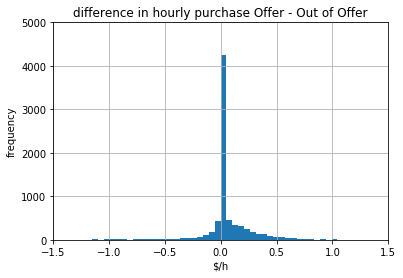

In [0]:
offer='c'
out.loc[out.offer==offer,'Avg_D_O'].hist(bins=1000)
plt.axis([-1.5,1.5,0,5000]);
plt.title('difference in hourly purchase Offer - Out of Offer');
plt.xlabel('$/h');
plt.ylabel('frequency');
out.loc[out.offer==offer,'Avg_D_O'].mean()*31*24

In [0]:
pp=out.groupby(by=['person','offer'])['Tpay_offer','duration_effective'].agg('sum')
pp['duration_effective']=np.maximum(pp['duration_effective'],1+0*pp['duration_effective'])
ppa=(pp['Tpay_offer']/pp['duration_effective'])

oo=out.groupby(by='person')[['Tpay_out','tot_not_offers_time']].agg('mean')
ooa=oo['Tpay_out']/oo['tot_not_offers_time']

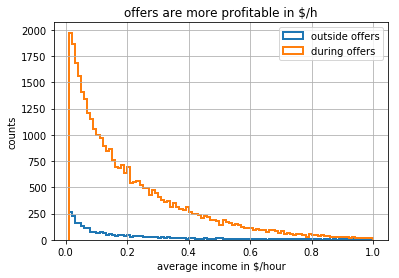

In [0]:
# ppa.loc[ppa.offer=='a'].hist(bins=500,histtype='step');
bins=np.linspace(1/100,1,100)
density=False

ooa.hist(bins=bins,histtype='step',density = density,label='outside offers',lw=2);
ppa.hist(bins=bins,histtype='step',density = density,label='during offers',lw=2);
plt.xlabel('average income in $/hour')
plt.ylabel('counts')

#plt.axis([0,1.0,0,5]);
plt.legend(loc=0);
plt.title('offers are more profitable in $/h');

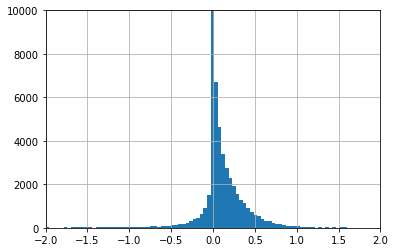

In [0]:
di=ppa-ooa
di.hist(bins=2000)
plt.axis([-2,2,0,1e4]);

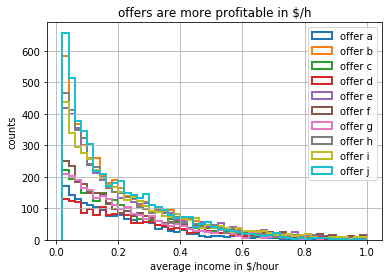

In [0]:
step=50
bins=np.linspace(1/step,1,step)
#ooa.hist(bins=bins,histtype='step',density = False,label='outside offers',lw=2);
for off in np.unique(out.offer ):
  ppa.loc[ppa.index.get_level_values('offer')==off].hist(bins=bins,histtype='step',density = False,label='offer '+off,lw=2);

plt.xlabel('average income in $/hour')
plt.ylabel('counts')

#plt.axis([0,1.0,0,5]);
plt.legend(loc=0);
plt.title('offers are more profitable in $/h');

In [0]:
success=out.groupby(by=['offer'])['viewed','completed','comp_not_viewed','received'].sum()
success['completed percentage']=100.*success['completed']/success['viewed']
success['cnv percentage']=100.*success['comp_not_viewed']/success['received']


Text(0, 0.5, 'percentage')

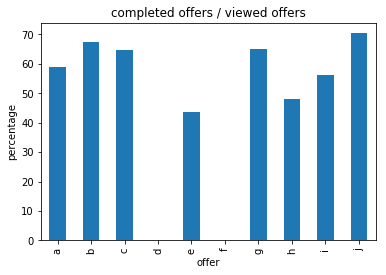

In [0]:
success['completed percentage'].plot(kind='bar')
plt.title('completed offers / viewed offers')
plt.ylabel('percentage')

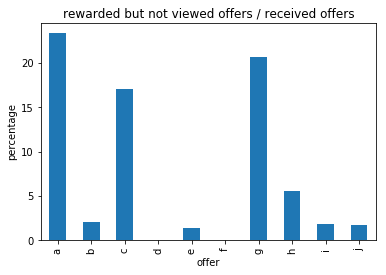

In [0]:
success['cnv percentage'].plot(kind='bar')
plt.title('rewarded but not viewed offers / received offers')
plt.ylabel('percentage');